In [1]:
using Plots
using LightGraphs
using LinearAlgebra
using BenchmarkTools
using SparseArrays
using Random
using LaTeXStrings

In [65]:
function randomPopulateMat(mat,symmetric=true)
    for ii = 1:round(Int, percPopulate*size(mat)[1] )
        row_tmp = rand( 1:size(mat)[1] )
        col_tmp = rand( 1:size(mat)[1] )
        if( row_tmp == col_tmp )
            col_tmp = rand( deleteat!( collect(1:size(mat)[1]), row_tmp ) )            
        end
        mat[row_tmp,col_tmp] = 1
        if(symmetric == true)
            mat[col_tmp,row_tmp] = 1
        end
    end
    return mat
end

randomPopulateMat (generic function with 2 methods)

In [3]:
function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end

A2S (generic function with 1 method)

In [4]:
function A2k(SMat,k)
    return SMat^k
end

A2k (generic function with 1 method)

In [5]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 20
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 5

5

In [68]:
benchmarkDicts = Dict()
benchmarkDicts["time"] = []
benchmarkDicts["memory"] = []
benchmarkDicts["gctime"] = []
benchmarkDicts["allocs"] = []
NN = [10^k for k in 1:5] #[10^1,10^2,10^3,10^4,10^5]
percPopulate = 0.1
for ii in 1:length(NN)
    NNtmp = NN[ii]
    AA = spzeros(NNtmp,NNtmp);
    AA = randomPopulateMat(AA);
    bb = @benchmark A2S(AA)
    push!(benchmarkDicts["time"],mean(bb).time)
    push!(benchmarkDicts["memory"],mean(bb).memory)
    push!(benchmarkDicts["gctime"],mean(bb).gctime)
    push!(benchmarkDicts["allocs"],mean(bb).allocs)
    
end

In [69]:
benchmarkDicts["time"]

5-element Array{Any,1}:
   1249.0892857142858
   5797.3125
  33359.5
 411667.5
      4.32103835e6

In [70]:
benchmarkDicts["memory"]

5-element Array{Any,1}:
     2704
    14096
   124944
  1227760
 12261696

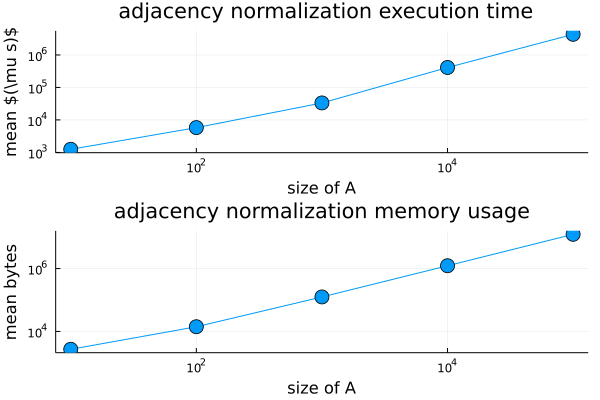

In [72]:
pTime = plot( NN , benchmarkDicts["time"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean " * L"(\mu s)")
title!(" adjacency normalization execution time")
pMemory = plot( NN , benchmarkDicts["memory"] ,markershape=:circle, markersize=8 ,
        legend = false , xaxis=:log , yaxis=:log)
xlabel!("size of A")
ylabel!("mean bytes")
title!("adjacency normalization memory usage")
plot(pTime, pMemory, layout = Plots.grid(2,1) )

In [87]:
benchmarkDicts_k = Dict()
benchmarkDicts_k["time"] = []
benchmarkDicts_k["memory"] = []
benchmarkDicts_k["gctime"] = []
benchmarkDicts_k["allocs"] = []
NN = [10^6]
percPopulate = 0.1
NNtmp = NN[1]
AA = spzeros(NNtmp,NNtmp);
AA = randomPopulateMat(AA);
AS = A2S(AA)
K = [0,1,2,3,4,6]
for ii in 1:length(K)
    kk = K[ii]
    bb = @benchmark A2k(AS,$kk)
    push!(benchmarkDicts_k["time"],mean(bb).time)
    push!(benchmarkDicts_k["memory"],mean(bb).memory)
    push!(benchmarkDicts_k["gctime"],mean(bb).gctime)
    push!(benchmarkDicts_k["allocs"],mean(bb).allocs)
    
end

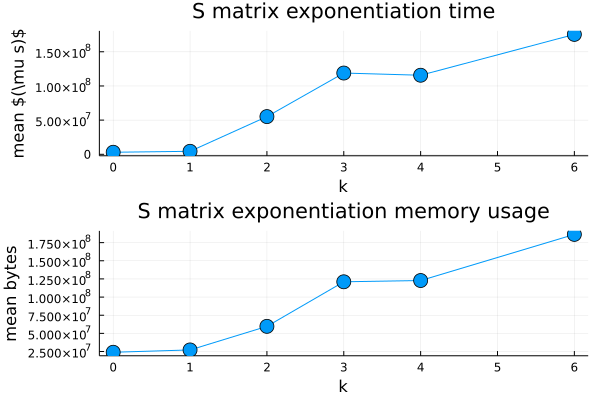

In [88]:
pTime = plot( K , benchmarkDicts_k["time"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean " * L"(\mu s)")
title!("S matrix exponentiation time")
pMemory = plot( K , benchmarkDicts_k["memory"] ,markershape=:circle, markersize=8 ,
        legend = false )
xlabel!("k")
ylabel!("mean bytes")
title!("S matrix exponentiation memory usage")
plot(pTime, pMemory, layout = Plots.grid(2,1) )

In [ ]:
x = 1:0.5:20
y = 1:0.5:10
f(x, y) = begin
        (3x + y ^ 2) * abs(sin(x) + cos(y))
    end
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))
Z = map(f, X, Y)
p1 = contour(x, y, f, fill = true)
p2 = contour(x, y, Z)
plot(p1, p2)

In [90]:
xx = [1,2,3,4]
yy = [10,20,30,40]
zz = [ii^2 for ii in 1:(length(xx)*length(yy))];

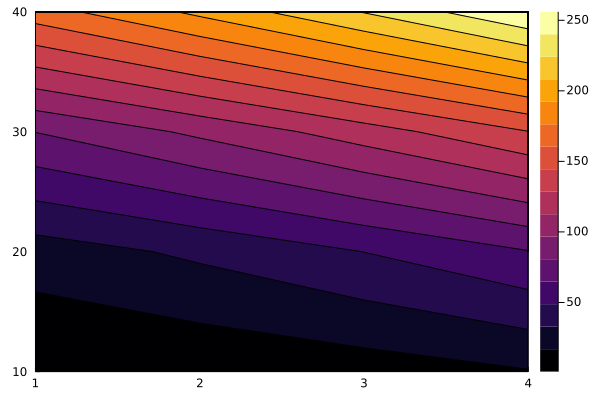

In [92]:
contour(xx,yy,zz,fill=true) #contourf(x, y, z, clims=(0u"m/s", 3u"m/s"))

In [72]:
@benchmark A2S(AA)

BenchmarkTools.Trial: 100 samples with 6 evaluations.
 Range (min … max):   6.906 μs …  14.133 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      9.935 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.012 μs ± 751.256 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

                             ▂█▃▆▂▆█▂  ▅ █                      
  ▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▁▁▁▁▁▁▇███████████▇█▅▇▄▅▄▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄ ▄
  6.91 μs         Histogram: frequency by time         12.4 μs <

 Memory estimate: 13.77 KiB, allocs estimate: 22.

In [7]:
function adjacency2Smatrix(AdjMat)
    Adj = deepcopy(AdjMat)
    #make the diagonal for the adj matrix
    diag1 = zeros(size(Adj)[1],size(Adj)[2])
    [diag1[i,i]=1 for i in 1:size(diag1)[1]] 
    #add self-loops as the paper describes
    Adj .+= diag1
    #get degree matrix
    degrees = sum(Adj,dims=2)
    diag2 = zeros(size(Adj)[1],size(Adj)[2])
    [diag2[i,i]=degrees[i] for i in 1:size(diag1)[1]] 
    #make the diagonal matrix to the power of -1/2
    diag2 = diag2^(-1/2)
    #make the normalized S matrix
    S = diag2 * Adj * diag2
    return S
end

adjacency2Smatrix (generic function with 1 method)

In [9]:
as = adjacency2Smatrix(aa);
println(sum( (as)^1 ))
#println(sum( (as)^10 ))
#println(sum( (as)^100 ))
@btime adjacency2Smatrix(aa);

79.96632649518878
79.97113699635344
79.97113699587598
  64.377 μs (115 allocations: 260.78 KiB)


In [181]:
#now some synthetic data

In [118]:
function vizMatrixNormed(Adj,powerInd)#multiple dispatch
    global NN1
    hAdjNN1 = heatmap(Adj,title="Normalized Adjacency (S), k=$(powerInd)",
        showaxis=true,yaxis=:flip,aspect_ratio=1.0,
        framestyle=:box,xlims=(0.0,NN1+1.0),
        legend=true,ylims=(0.0,NN1+0.5),
        yticks=0:5:NN1,xticks=0:5:NN1,
        fill=cgrad([:white,:black]))
    return hAdjNN1
end

vizMatrixNormed (generic function with 1 method)

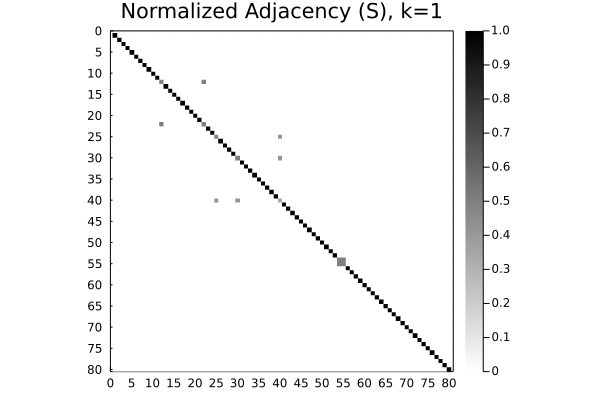

In [123]:
#adjMatrixNorm = adjacency2Smatrix(deepcopy(adjMatrix))
NN1 = 80
hVarX2 = vizMatrixNormed(as,1)